In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

In [2]:
# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Moonshot
def detect_moonshot(data, window=12, threshold=0.10):
    moonshots = []
    for i in range(len(data) - window):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน 12 ชั่วโมงจากครั้งก่อน
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        # เงื่อนไข: ราคาขึ้น >= 10% และ low ไม่ลดเกิน 3%
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            moonshots.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'high_price': high_price,
                'moonshot_pct': moonshot_pct * 100,
                'window_end_time': data.index[i+window-1]
            })
    return pd.DataFrame(moonshots)

In [4]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
data = data[['open', 'high', 'low', 'close']]  # เลือกคอลัมน์ที่จำเป็น

# ตรวจจับ Moonshot ด้วยเกณฑ์ 10% ใน 12 ชั่วโมง
moonshots = detect_moonshot(data, window=12, threshold=0.05)

In [5]:
# 1. การแจกแจงแบบรวม
print("Summary of Moonshot Sizes (Overall):")
moonshot_summary = {
    'Number of Moonshots': len(moonshots),
    'Mean Moonshot Size (%)': moonshots['moonshot_pct'].mean(),
    'Std Moonshot Size (%)': moonshots['moonshot_pct'].std(),
    'Min Moonshot Size (%)': moonshots['moonshot_pct'].min(),
    'Max Moonshot Size (%)': moonshots['moonshot_pct'].max(),
    'Median Moonshot Size (%)': moonshots['moonshot_pct'].median(),
    '25th Percentile (%)': moonshots['moonshot_pct'].quantile(0.25),
    '75th Percentile (%)': moonshots['moonshot_pct'].quantile(0.75)
}
for key, value in moonshot_summary.items():
    print(f"{key}: {value:.2f}")

Summary of Moonshot Sizes (Overall):
Number of Moonshots: 634.00
Mean Moonshot Size (%): 6.80
Std Moonshot Size (%): 2.69
Min Moonshot Size (%): 5.00
Max Moonshot Size (%): 27.52
Median Moonshot Size (%): 5.83
25th Percentile (%): 5.31
75th Percentile (%): 7.02


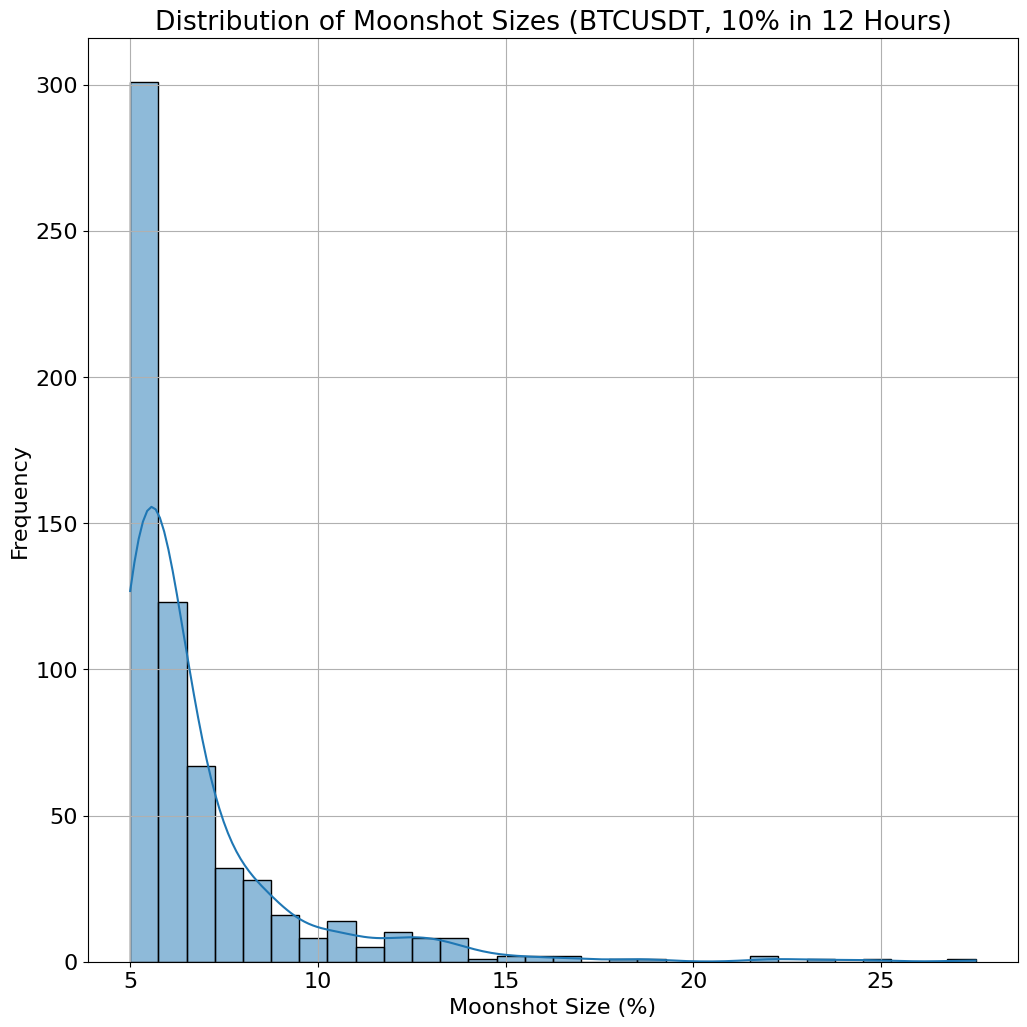

In [6]:
# สร้างฮิสโตแกรมของขนาด Moonshot
plt.figure(figsize=(12, 12))
sns.histplot(moonshots['moonshot_pct'], bins=30, kde=True)
plt.title('Distribution of Moonshot Sizes (BTCUSDT, 10% in 12 Hours)')
plt.xlabel('Moonshot Size (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
# ทดสอบความปกติของการแจกแจง
stat, p_value = stats.shapiro(moonshots['moonshot_pct'].sample(min(5000, len(moonshots))))
print(f"Shapiro-Wilk Test for Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("The distribution is not normal (p < 0.05)")
else:
    print("The distribution is normal (p >= 0.05)")

Shapiro-Wilk Test for Normality: stat=0.6282, p-value=0.0000
The distribution is not normal (p < 0.05)


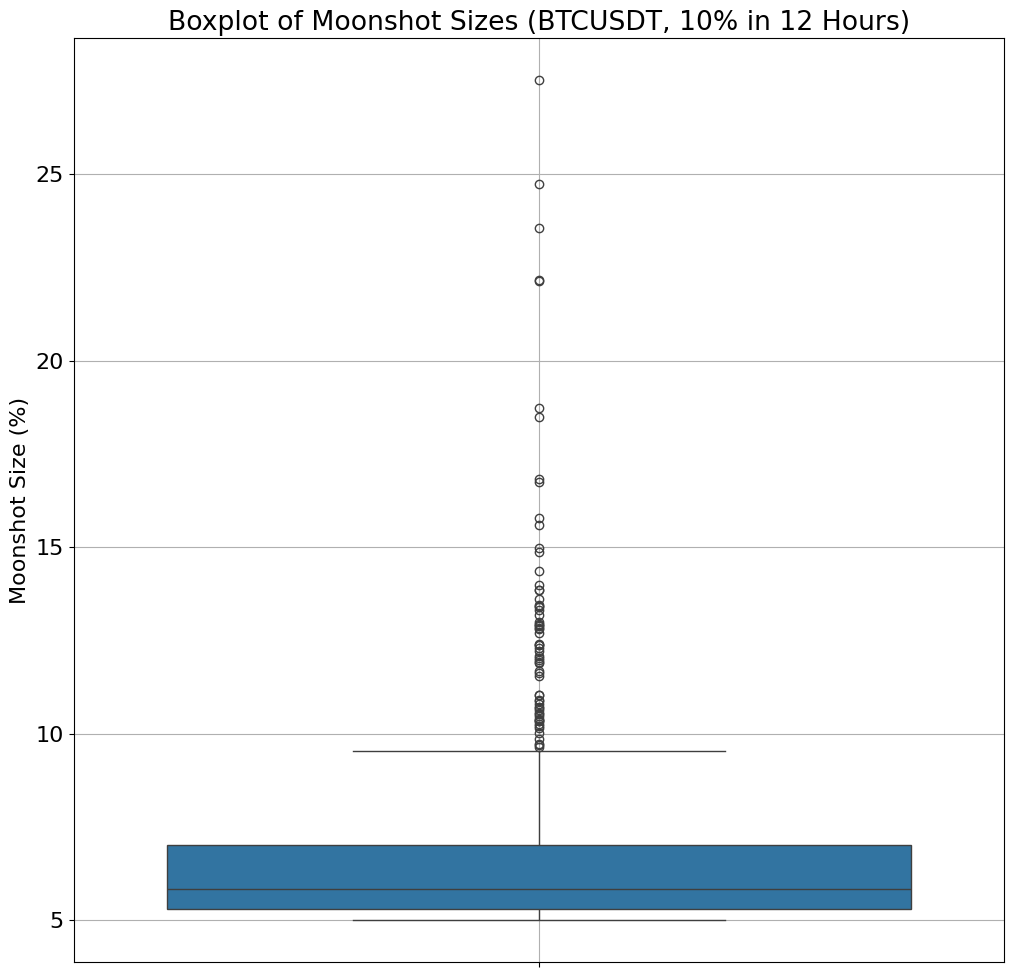

In [8]:
# สร้าง Boxplot ของขนาด Moonshot
plt.figure(figsize=(12, 12))
sns.boxplot(y=moonshots['moonshot_pct'])
plt.title('Boxplot of Moonshot Sizes (BTCUSDT, 10% in 12 Hours)')
plt.ylabel('Moonshot Size (%)')
plt.grid(True)
plt.show()

In [9]:
# 2. การแจกแจงรายเดือน
moonshots['month'] = moonshots['start_time'].dt.to_period('M')
monthly_summary = moonshots.groupby('month').agg({
    'moonshot_pct': ['count', 'mean', 'std', 'median'],
}).reset_index()
monthly_summary.columns = ['Month', 'Number of Moonshots', 'Mean Moonshot Size (%)', 'Std Moonshot Size (%)', 'Median Moonshot Size (%)']
print("\nMonthly Moonshot Summary:")
print(monthly_summary.to_string(index=False))


Monthly Moonshot Summary:
  Month  Number of Moonshots  Mean Moonshot Size (%)  Std Moonshot Size (%)  Median Moonshot Size (%)
2017-08                    6                7.116038               3.444130                  5.503369
2017-09                   24                7.191714               3.171329                  5.737925
2017-10                   12                6.535862               1.760424                  5.863241
2017-11                   25                7.110848               3.327782                  5.579244
2017-12                   29                8.717158               3.956923                  7.049120
2018-01                   30                8.116404               4.553908                  6.217594
2018-02                   24                7.865945               4.177042                  6.056399
2018-03                   17                6.828719               1.856696                  6.333497
2018-04                   10                6.454807   

/tmp/ipykernel_54030/1004852481.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  moonshots['month'] = moonshots['start_time'].dt.to_period('M')


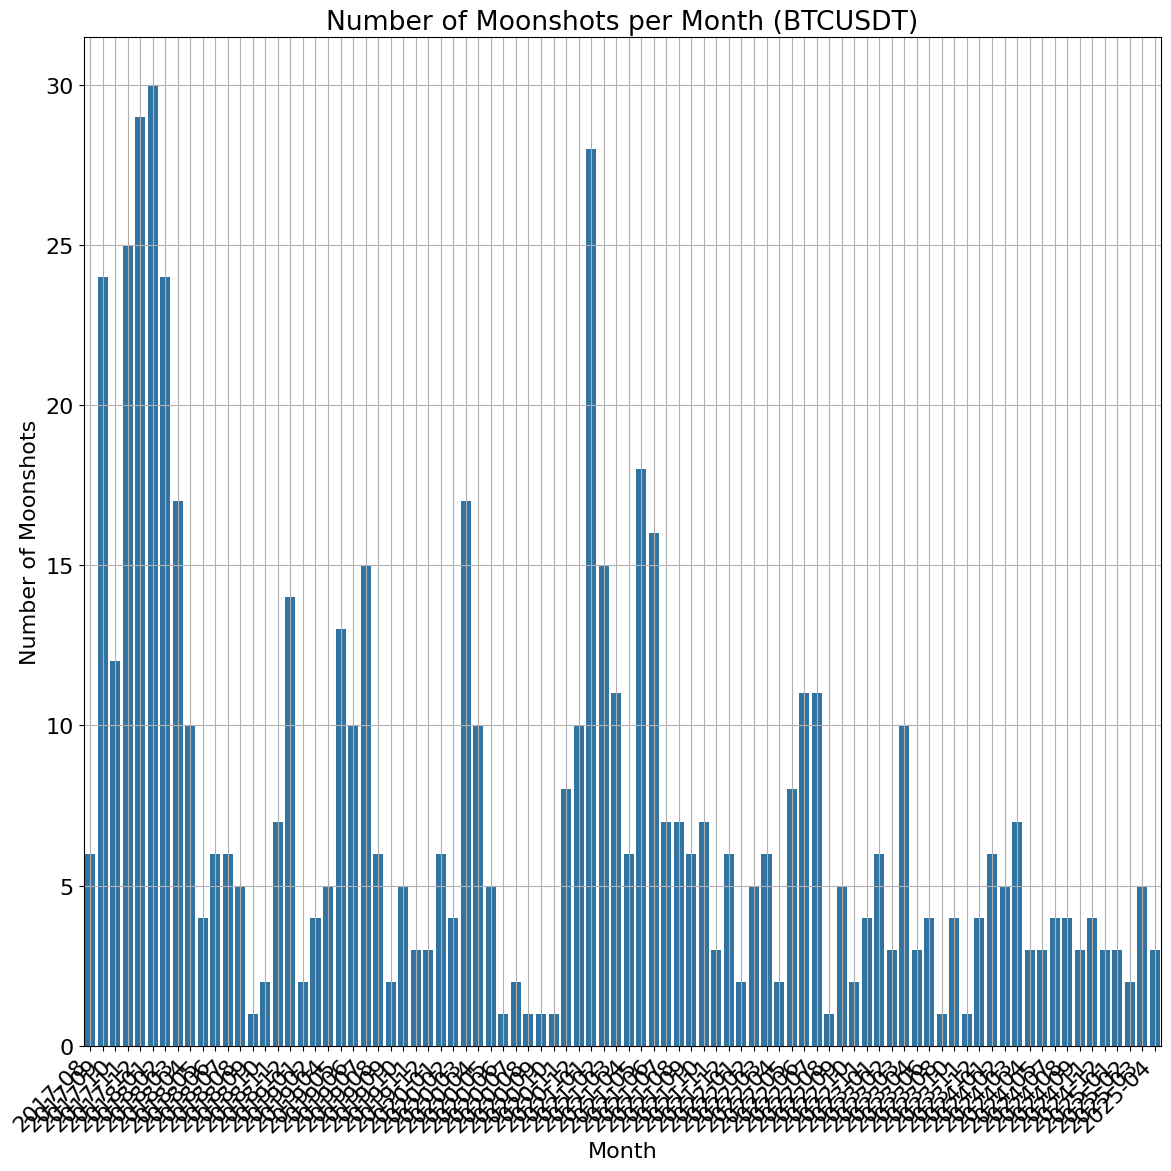

In [10]:
# สร้างกราฟจำนวน Moonshot รายเดือน
plt.figure(figsize=(12, 12))
sns.countplot(x=moonshots['month'].dt.strftime('%Y-%m'), order=sorted(moonshots['month'].dt.strftime('%Y-%m').unique()))
plt.title('Number of Moonshots per Month (BTCUSDT)')
plt.xlabel('Month')
plt.ylabel('Number of Moonshots')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# 3. การแจกแจงรายปีและแนวโน้ม
moonshots['year'] = moonshots['start_time'].dt.year
yearly_summary = moonshots.groupby('year').agg({
    'moonshot_pct': ['count', 'mean', 'std', 'median'],
}).reset_index()
yearly_summary.columns = ['Year', 'Number of Moonshots', 'Mean Moonshot Size (%)', 'Std Moonshot Size (%)', 'Median Moonshot Size (%)']
print("\nYearly Moonshot Summary:")
print(yearly_summary.to_string(index=False))


Yearly Moonshot Summary:
 Year  Number of Moonshots  Mean Moonshot Size (%)  Std Moonshot Size (%)  Median Moonshot Size (%)
 2017                   96                7.544755               3.386937                  5.968787
 2018                  126                7.146288               3.246346                  5.993923
 2019                   68                6.807956               2.820826                  5.764785
 2020                   66                6.915881               3.192535                  5.766536
 2021                  130                6.554552               1.936257                  5.961801
 2022                   57                6.521036               1.895257                  5.644626
 2023                   36                6.041226               1.585455                  5.654900
 2024                   42                5.830907               1.144764                  5.425719
 2025                   13                6.415731               1.169619 

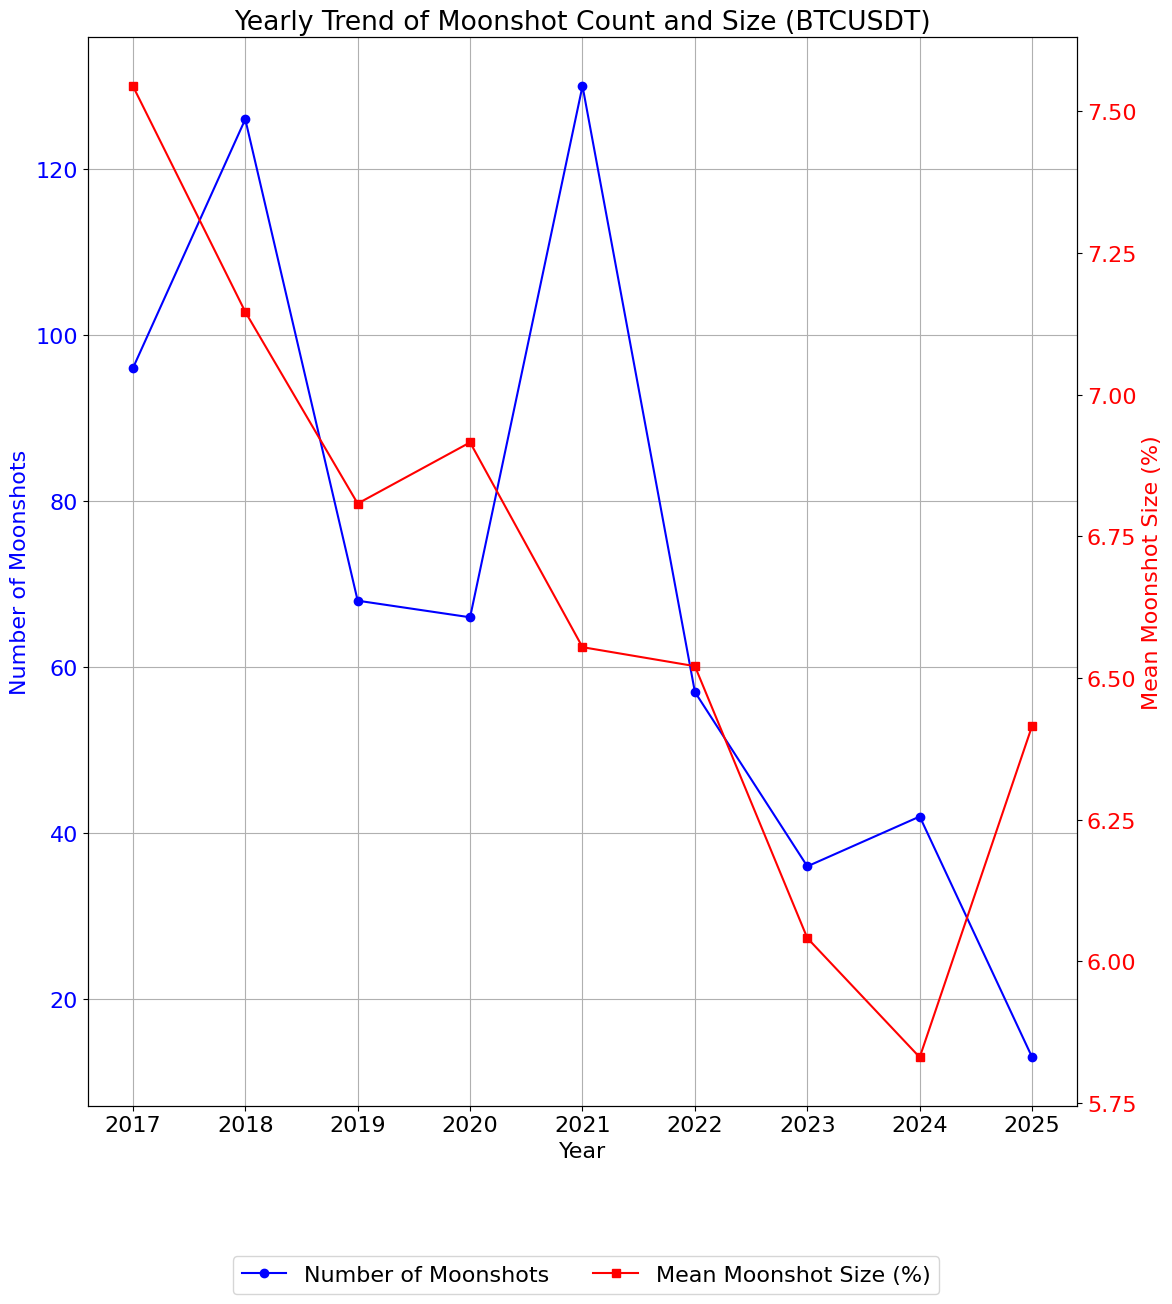

In [12]:
# สร้างกราฟแนวโน้มจำนวนและขนาดเฉลี่ยของ Moonshot รายปี
fig, ax1 = plt.subplots(figsize=(12, 12))
ax1.plot(yearly_summary['Year'], yearly_summary['Number of Moonshots'], marker='o', color='b', label='Number of Moonshots')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Moonshots', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(yearly_summary['Year'], yearly_summary['Mean Moonshot Size (%)'], marker='s', color='r', label='Mean Moonshot Size (%)')
ax2.set_ylabel('Mean Moonshot Size (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Yearly Trend of Moonshot Count and Size (BTCUSDT)')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()